# Explore here

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93

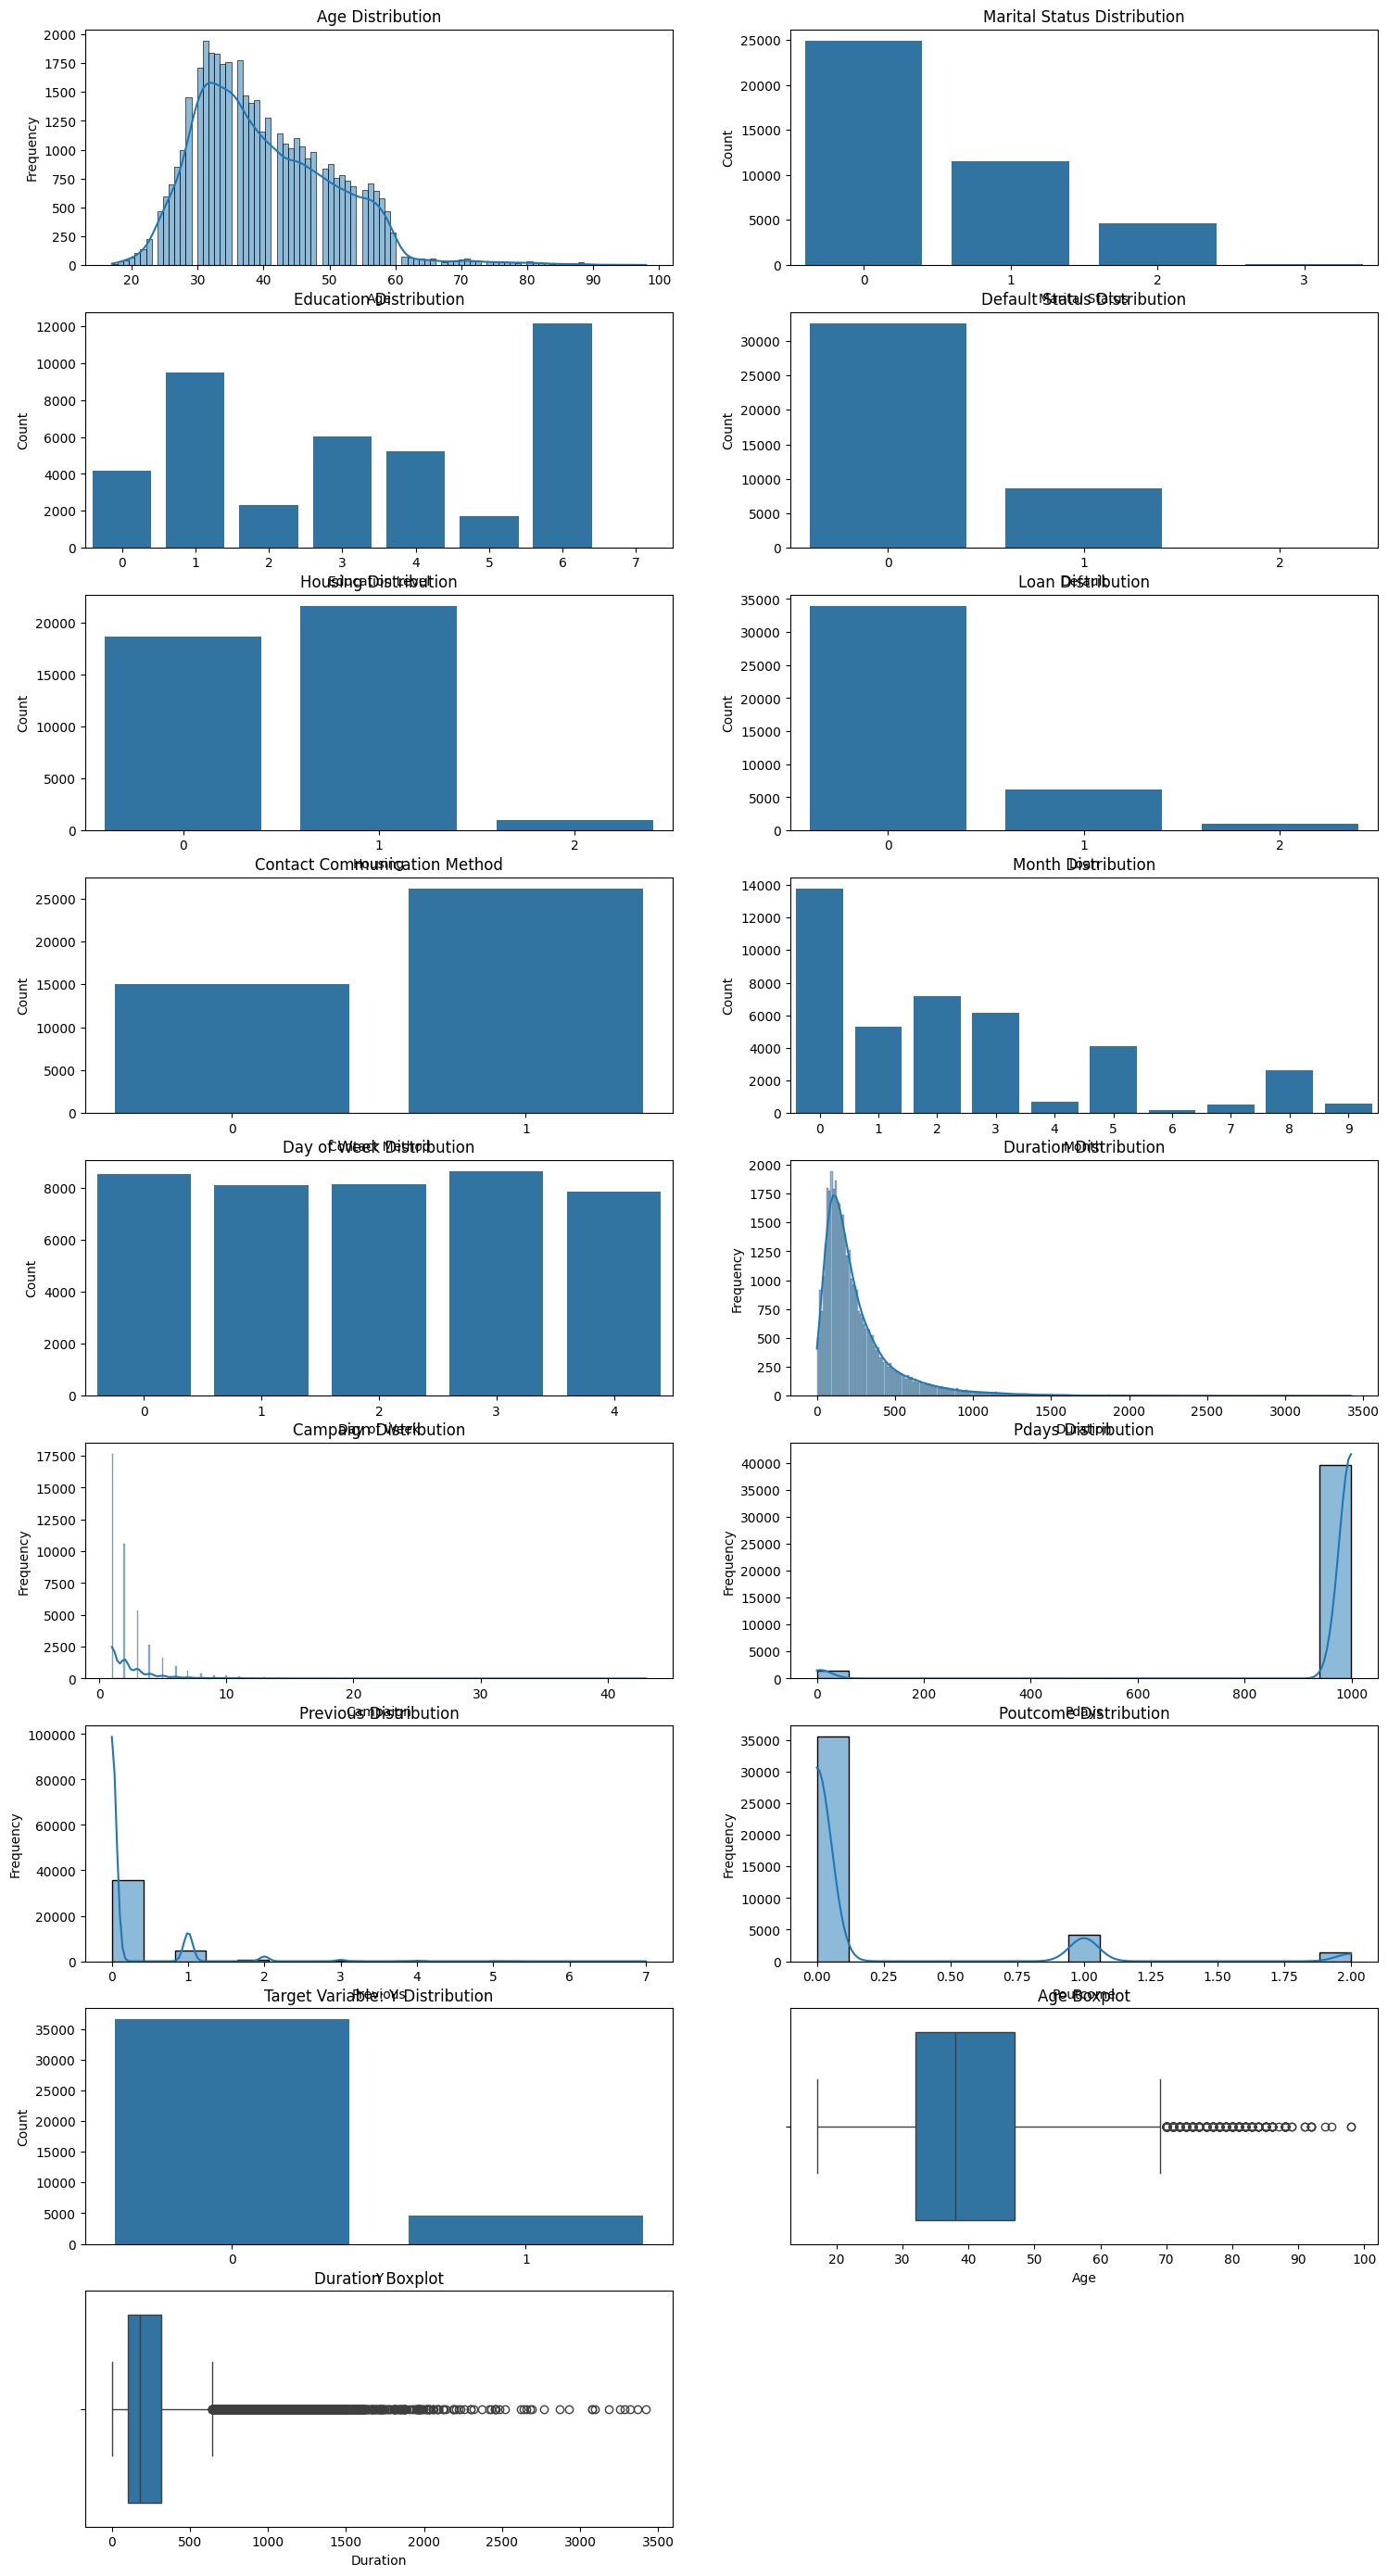

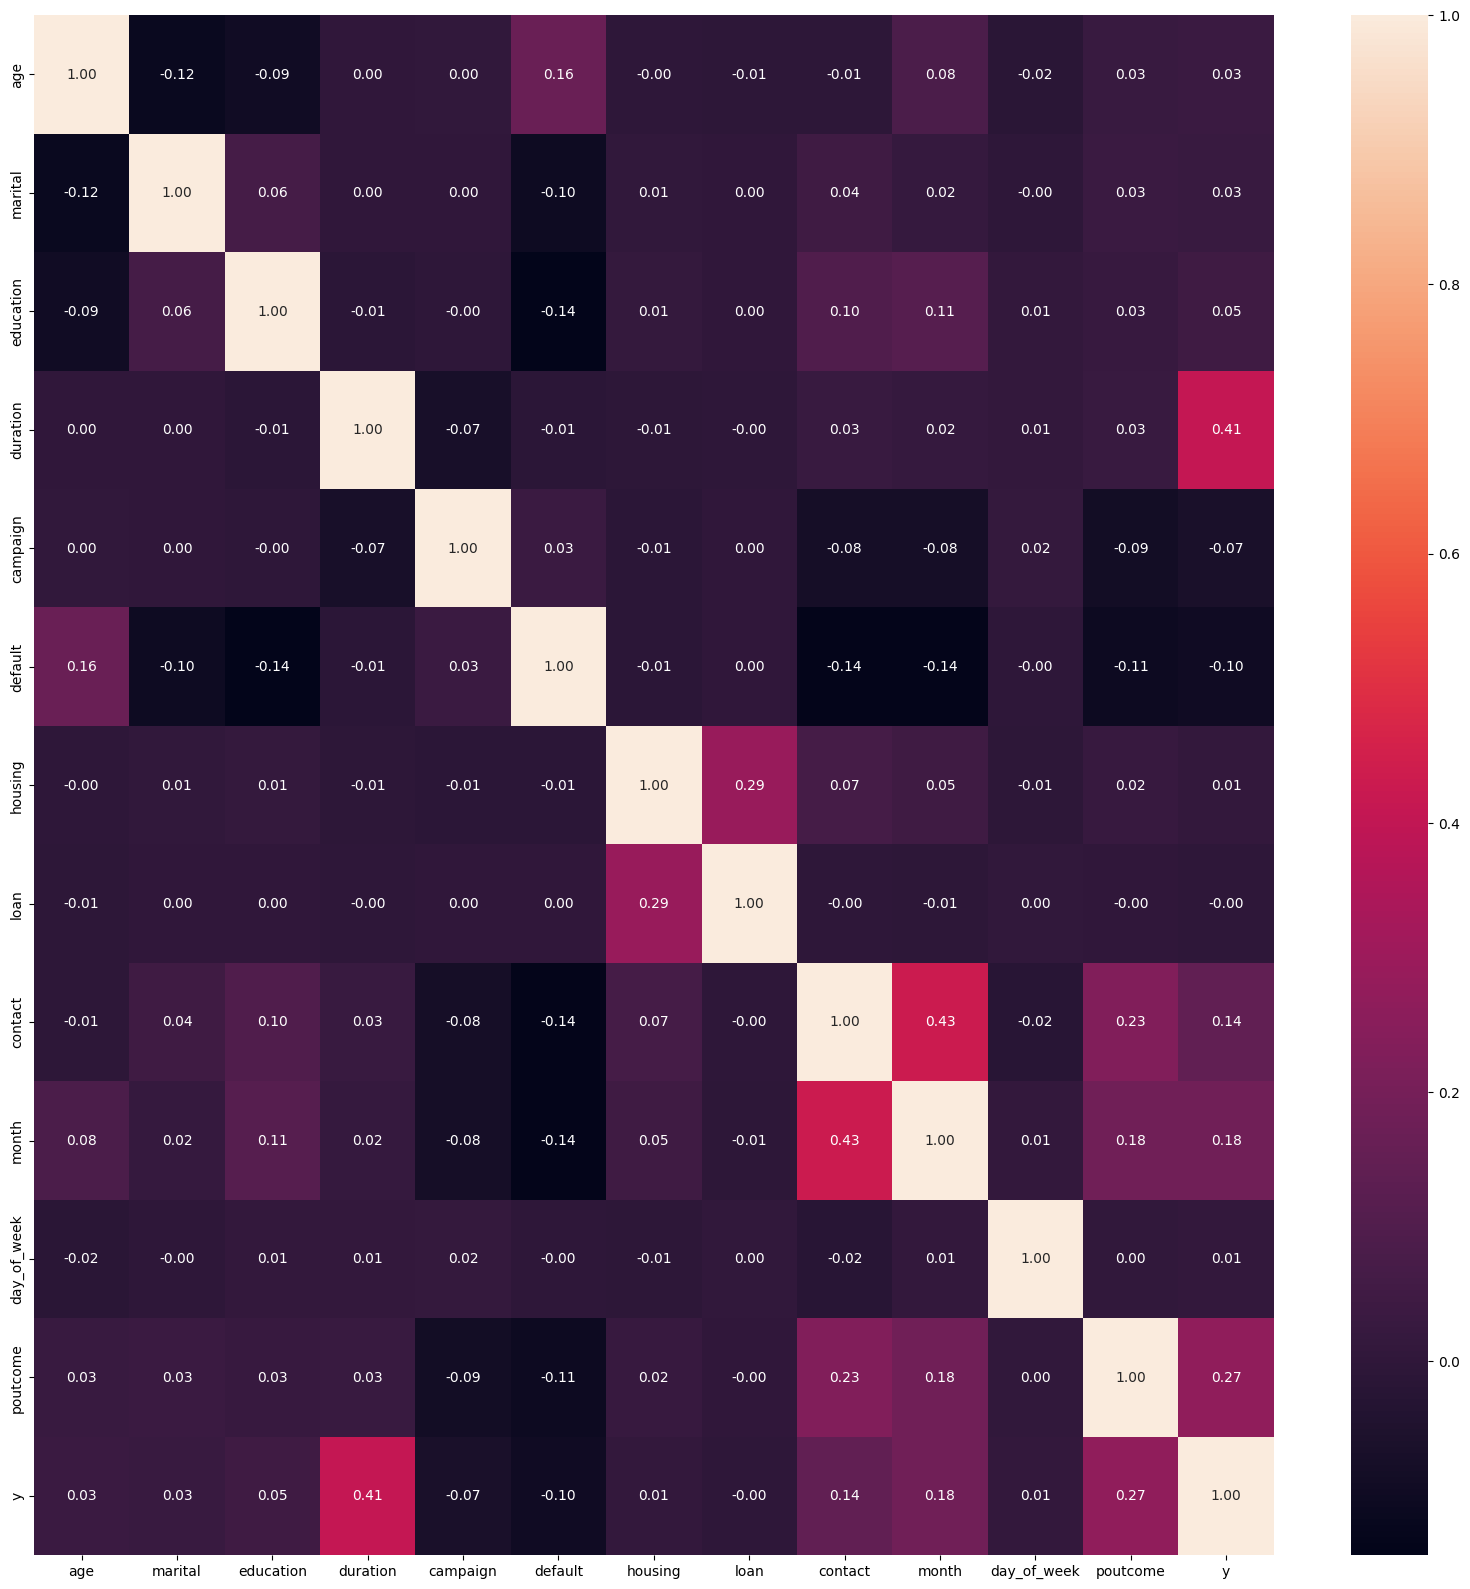

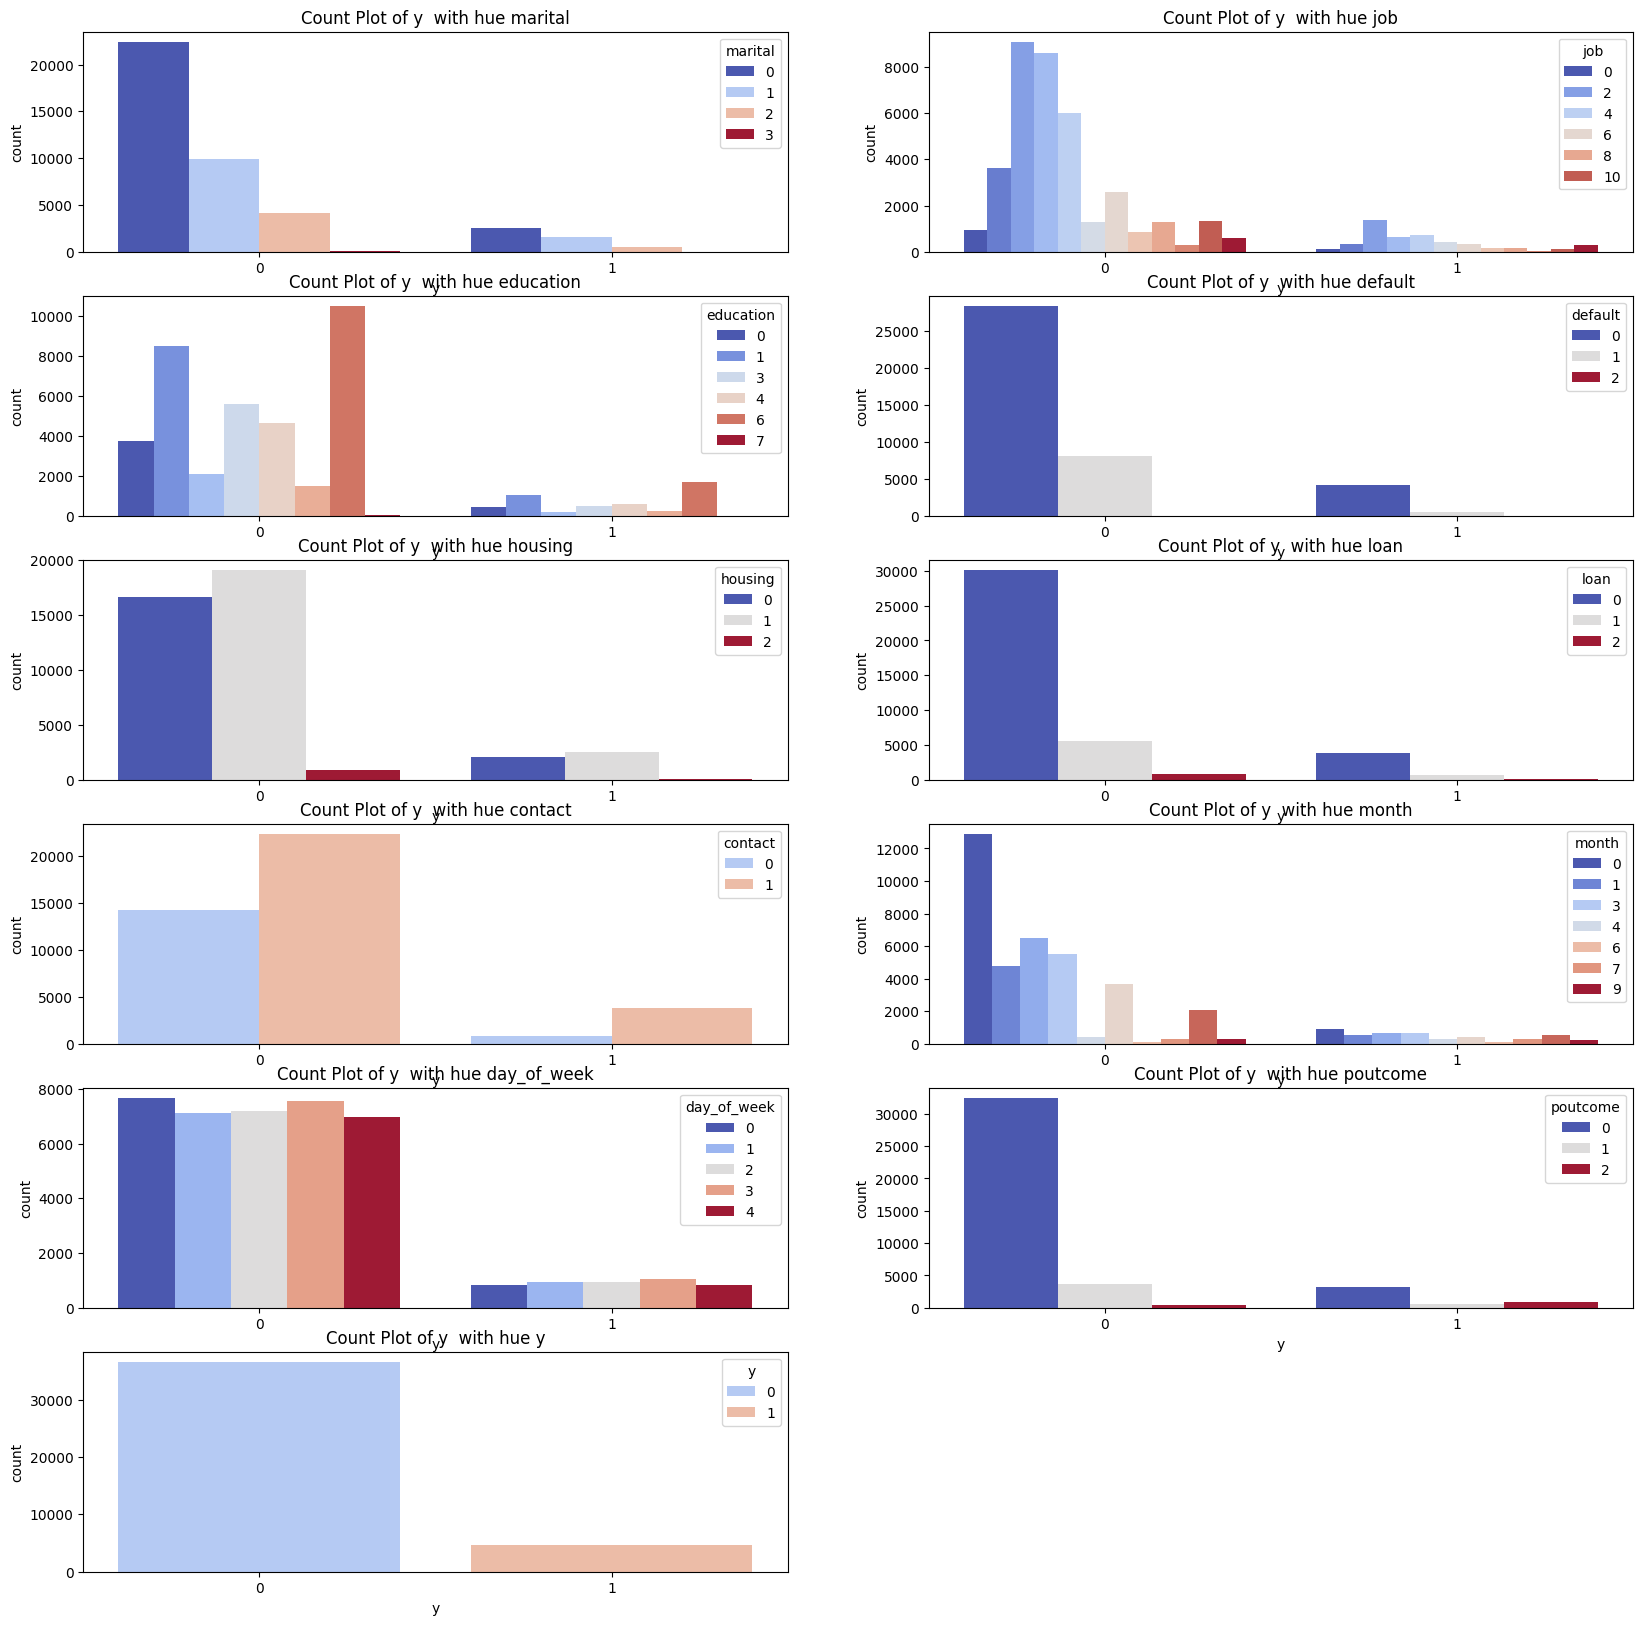

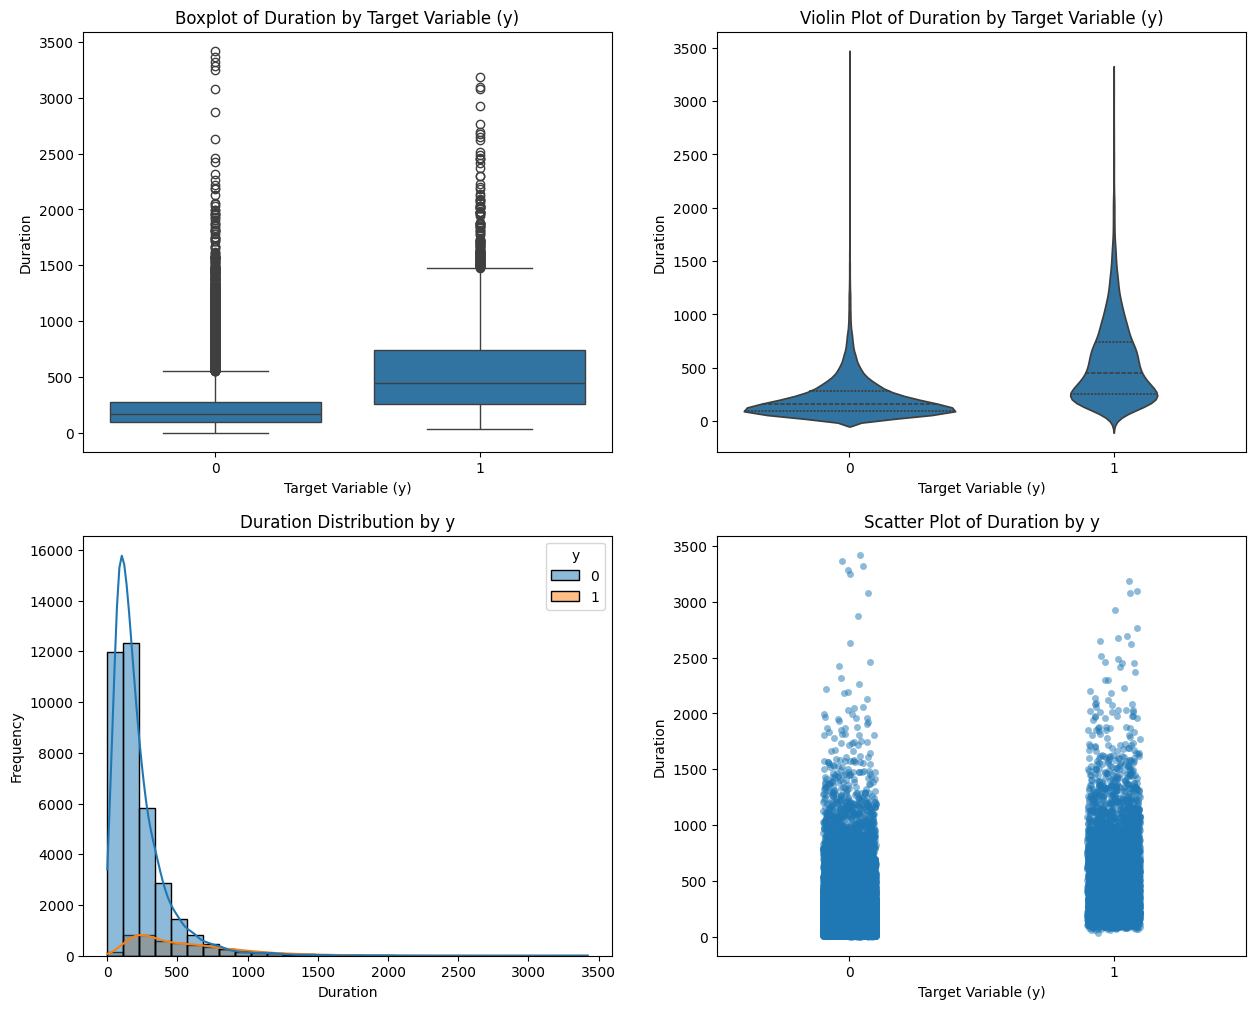

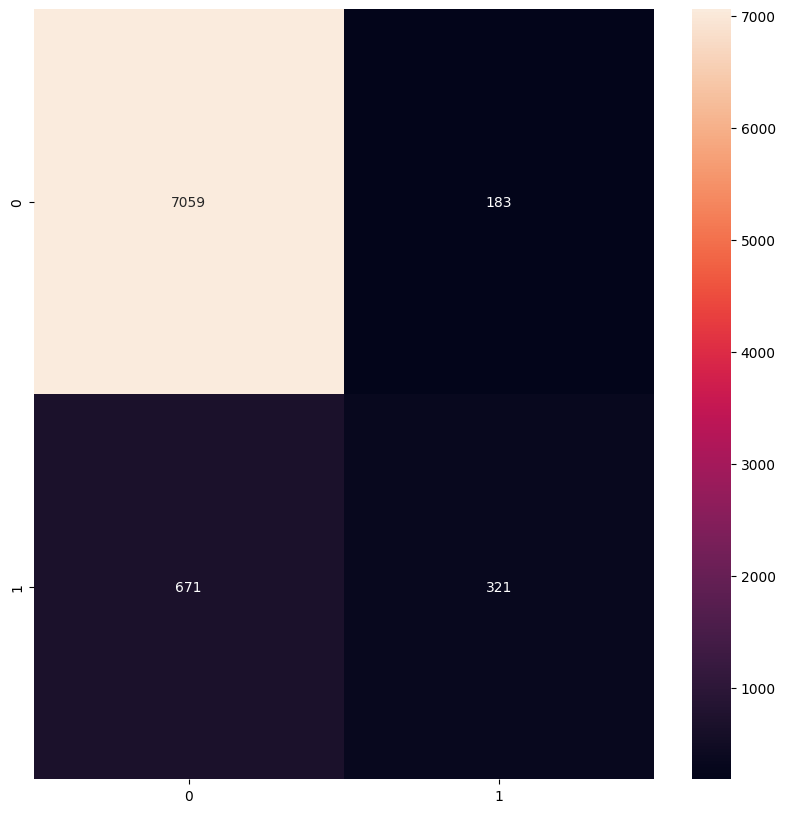

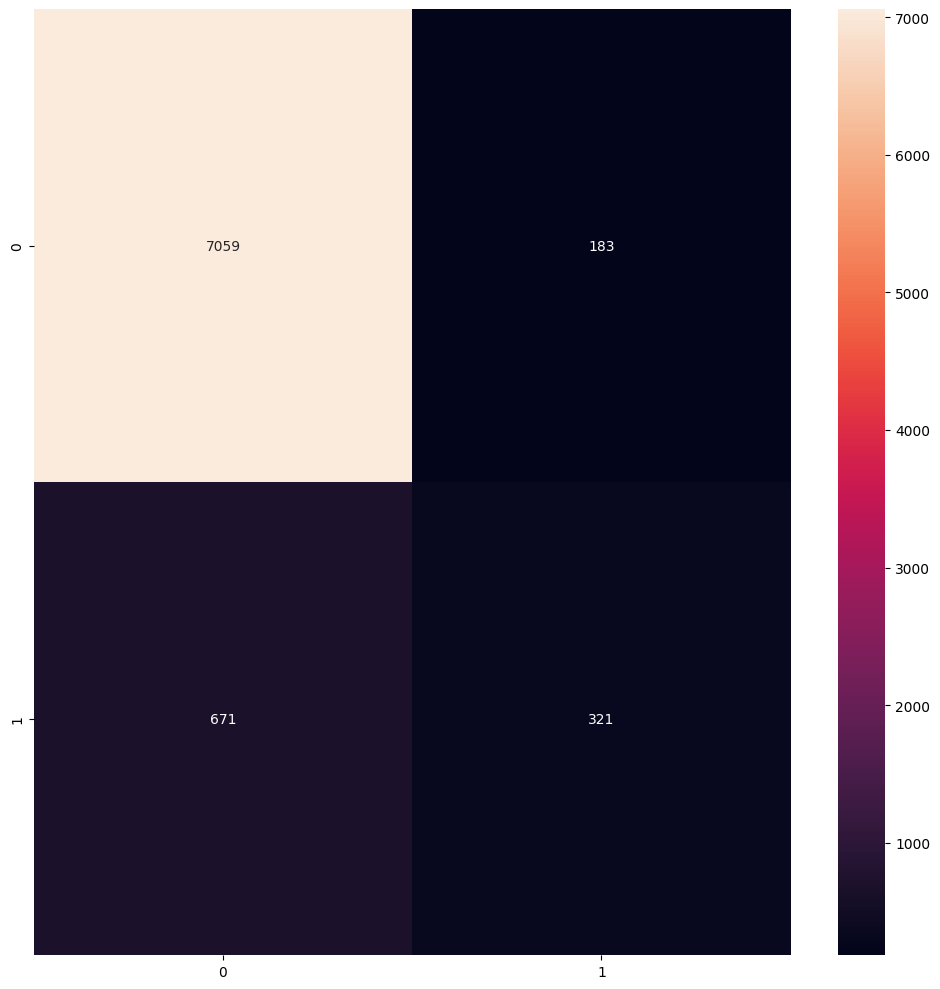

In [1]:
# Your code here
from utils import db_connect
engine = db_connect()

# your code here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functions import create_univariate_charts, create_multivariate_charts

pd.set_option('display.max_columns', None)

 #%%

customer_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv', sep=';')
print(customer_data.head())

# STEP 1: PERFORM EDA

# Gain first insights into dataset
print(customer_data.info())
print(customer_data.describe())

# Handle duplicates
duplicates = customer_data.duplicated().sum()
if duplicates !=0:
    customer_data.drop_duplicates(inplace=True)

# Remove dimensions unrelated to business problem

customer_data.drop(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1, inplace=True)

# Convert categorical values to numerical
cat_dimensions = ['marital', 'job', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

# Dictionary to store mapping
factorize_mappings = {}

for col in cat_dimensions:
    encoded_value, categories = pd.factorize(customer_data[col])
    factorize_mappings[col] = dict(enumerate(categories))
    customer_data[col] = encoded_value
print(customer_data.head())
print(customer_data.info())
print(factorize_mappings)

# Handle outliers
print(customer_data.loc[customer_data['duration'] >= 3500 ])
print(customer_data.loc[customer_data['campaign'] >= 45 ])
customer_data = customer_data[customer_data['campaign'] <= 45]
customer_data = customer_data[customer_data['duration'] <= 3500]

# Visualize univariate values
create_univariate_charts(customer_data)

# Visualize multivariate values
create_multivariate_charts(customer_data, cat_dimensions)

from sklearn.model_selection import train_test_split

X = customer_data.drop('y', axis=1)
y = customer_data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

# Normalization

from sklearn.feature_selection import f_classif, SelectKBest

selection_model = SelectKBest(f_classif, k=7)
selection_model.fit(X_train_norm, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[ix])

# Reapply normalization
scaler.fit(X_train_sel)
X_train_sel_norm = scaler.transform(X_train_sel)
X_test_sel_norm = scaler.transform(X_test_sel)
X_train_sel_norm = pd.DataFrame(X_train_sel_norm, columns=X_train.columns.values[ix])
X_test_sel_norm = pd.DataFrame(X_test_sel_norm, columns=X_test.columns.values[ix])

# Run logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_sel_norm, y_train)

predictions = model.predict(X_test_sel_norm)

# Evaluate performances
from sklearn.metrics import accuracy_score, confusion_matrix

acc_score = accuracy_score(y_test, predictions)
print(acc_score)
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt='d')

# Apply hyperparameters

from sklearn.model_selection import GridSearchCV

hyperparams = {
    'C': [0.001,0.01,0.1, 1, 10, 100, 1000],
    'penalty': ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

grid = GridSearchCV(model, hyperparams, scoring='accuracy', cv=5)

# Suppress warnings due to incopatibilities or converges
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train_sel_norm, y_train)
print(f'Best parameters: {grid.best_params_}')

# Re-run logistic regression
opt_model = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
opt_model.fit(X_train_sel_norm, y_train)

opt_predictions = opt_model.predict(X_test_sel_norm)

# Re-evaluate performances
acc_score = accuracy_score(y_test, opt_predictions)
print(acc_score)
opt_cm = confusion_matrix(y_test, predictions)
opt_cm_df = pd.DataFrame(cm)
plt.figure(figsize=(10,10))
sns.heatmap(opt_cm_df, annot=True, fmt='d')

plt.tight_layout()
plt.show()